<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/0509_%ED%9A%8C%EA%B7%802_%EB%A6%BF%EC%A7%80~_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

Degree가 너무 작으면 예측 곡선이 지나치게 단순화되어 과소적합 모델이 만들어지고, 너무 커지면 다항식이 복잡해지면서 과대적합 모델이 만들어짐
-> 회귀계수가 너무 커지지 않으면서 동시에 데이터에 적절하게 적합한 회귀 모델을 만들어야 함, 또한 RSS도 최소한으로 하는 비용 함수를 선택해야

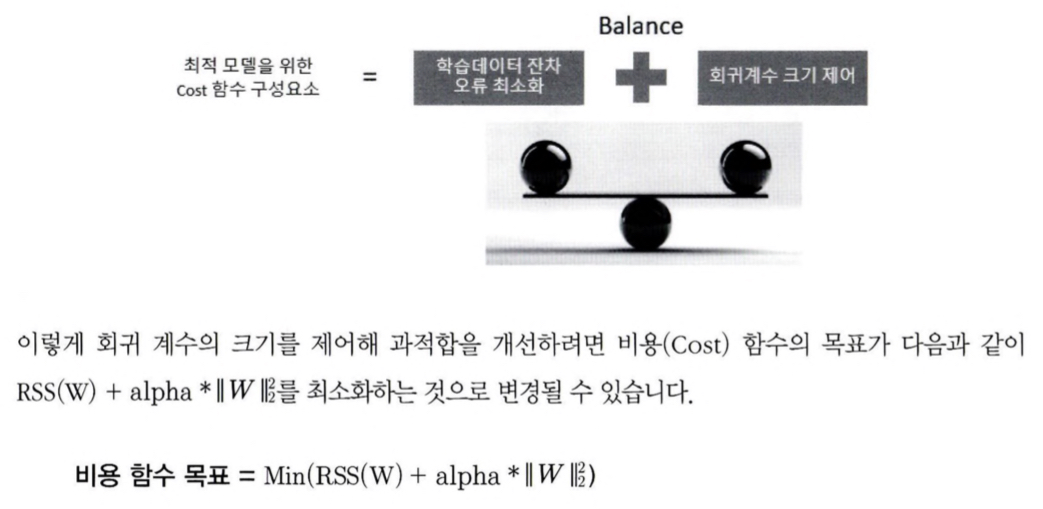

alpha: 학습 데이터의 적합 정도와 회귀 계수 값의 크기 제어를 수행하는 튜닝 파라미터. 비용함수의 목표는 위의 식을 최소화하는 W 벡터를 찾는 것인데, alpha가 매우 큰 값이면 비용 함수 식은 W를 매우 작게 만드는 방향으로 Cost가 최소화되는 비용 함수 목표를 달성함. 즉, alpha 값을 크게 하면 비용 함수는 회귀 계수 W의 값을 작게 해 과적합을 개선하며, 그 반대로도 적합을 개선. alpha 값으로 패널티를 부여해 회귀 계수 값의 크기를 감소시켜 과적합을 개선하는 방식을 **규제(Regularization)**이라고 함.

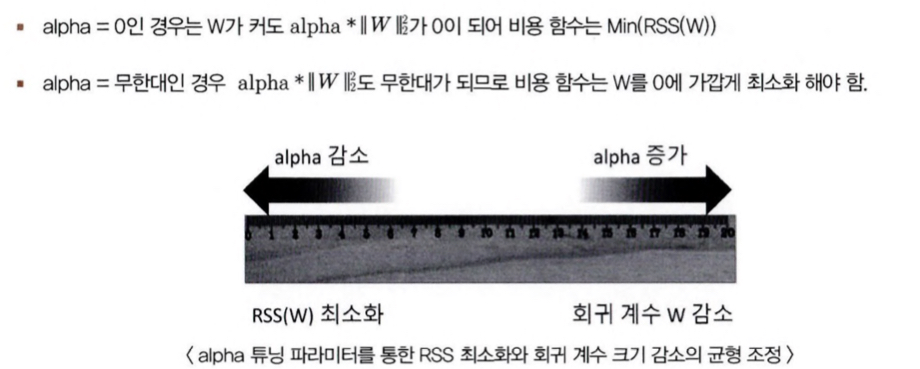

# 규제 - L1, L2

L2 - 릿지 회귀
: 위 식에서 W의 제곱에 대해 패널티를 부여하는 방식, 주요 생성 파라미터 alpha

L1 - 라쏘 회귀
: W의 절댓값에 패널티를 부여하는 방식, 영향력이 크지 않은 회귀 계수 값을 0으로 변환

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.datasets import fetch_openml

# boston 데이터 세트 로드
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['RAD'] = bostonDF['RAD'].astype(float)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = boston.target.astype(float)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
X_data = X_data.apply(pd.to_numeric, errors='coerce')
X_data = X_data.fillna(0)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha = 10으로 설정해 릿지 회귀 수행.
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


0505 필사에서 다뤘던 규제 없는 LinearRegression의 RMSE보다 더 뛰어난 예측 성능 보임

In [ ]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함.
for alpha in alphas :
  ridge = Ridge(alpha = alpha)


  # cross_val_score를 이용해 5 폴드의 평균 RMSE를 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring = "neg_mean_squared_error", cv = 5)
  avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
  print('alpha {0}일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330


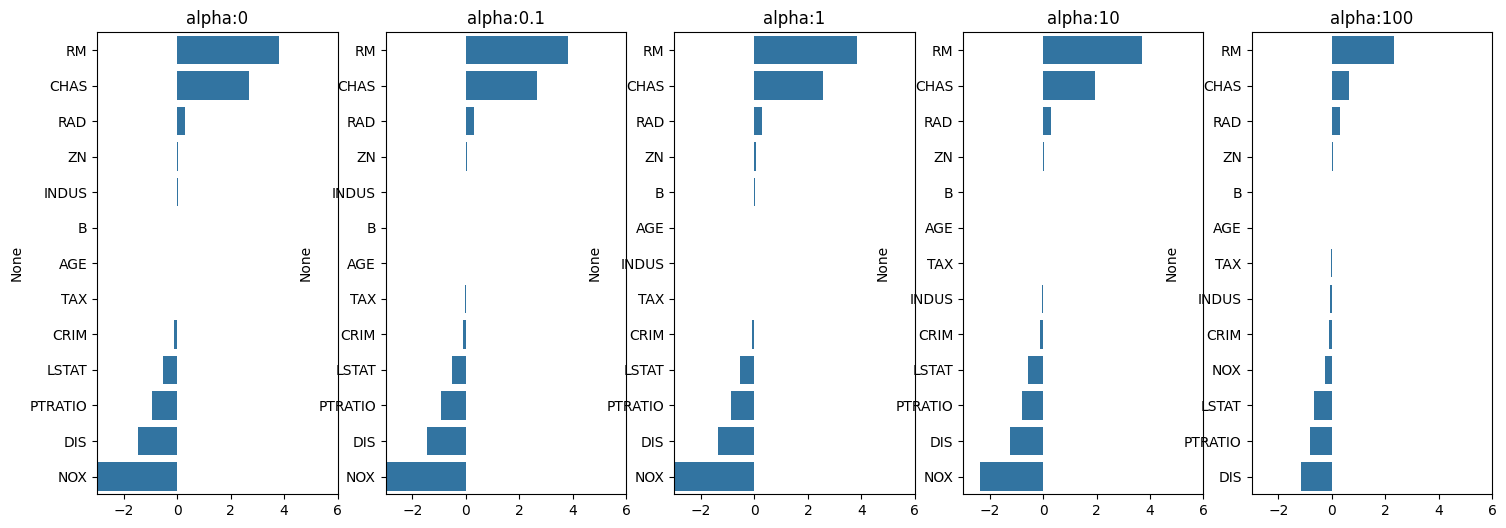

In [ ]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18, 6), nrows = 1, ncols =5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는axis의 위치지정
for pos, alpha in enumerate(alphas) :
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_data, y_target)
  # alpha에 다른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
  coeff = pd.Series(data = ridge.coef_, index = X_data.columns)
  colname = 'alpha:'+str(alpha)
  coeff_df[colname]= coeff
  # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending = False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

alpha 값을 증가시킬수록 회귀 계수 값은 지속적으로 작아짐

In [ ]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by = sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


alpha 값이 증가하면서 회귀 계수가 지속적으로 작아지고 있으나 릿지 회귀의 경우 회귀 계수가 0이 되진 않는다.

# 라쏘 회귀

L2 규제(릿지 회귀)가 회귀 계수의 크기를 감소시키는 데 반해, L1 규제(라쏘 회귀)는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만들고 제거함. 즉 L1 규제는 적절한 피처만 회귀에 포함시키는 피처 선택의 특성을 가지고 있음.

In [ ]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 반환
def get_linear_reg_eval(model_name, params = None, X_data_n = None, y_target_n = None,
                        verbose = True, return_coeff = True) :
  coeff_df = pd.DataFrame()
  if verbose : print('######', model_name, '######')
  for param in params :
    if model_name == 'Ridge' : model = Ridge(alpha = param)
    elif model_name == 'Lasso' : model = Lasso(alpha = param)
    elif model_name == 'ElasticNet' : model = ElasticNet(alpha = param, l1_ratio = 0.7)
    neg_mse_scores = cross_val_score(model, X_data_n,
                                     y_target_n, scoring = "neg_mean_squared_error", cv = 5)
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0}일 때 5 folds의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 회귀 계수 추출

    model.fit(X_data_n, y_target_n)
    if return_coeff :
      # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
      coeff = pd.Series(data = model.coef_, index = X_data_n.columns)
      colname = 'alpha:'+str(param)
      coeff_df[colname] = coeff

  return coeff_df
# end of get_linear_regre_eval

In [ ]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params = lasso_alphas, X_data_n = X_data, y_target_n = y_target)

###### Lasso ######
alpha 0.07일 때 5 folds의 평균 RMSE : 5.612
alpha 0.1일 때 5 folds의 평균 RMSE : 5.615
alpha 0.5일 때 5 folds의 평균 RMSE : 5.669
alpha 1일 때 5 folds의 평균 RMSE : 5.776
alpha 3일 때 5 folds의 평균 RMSE : 6.189


In [ ]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by = sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


릿지 회귀와 달리 alpha 크기 증가함에 따라 일부 피처의 회귀 계수는 0으로 바뀜 -> 회귀 식에 피처를 선택적으로 적용하여 피처 선택의 효과를 얻을 수 있음

# 엘라스틱넷 회귀

L2 규제와 L1 규제를 결합한 회귀. 엘라스틱넷 회귀 비용함수의 목표는 해당 식을 최소화하는 W를 찾는 것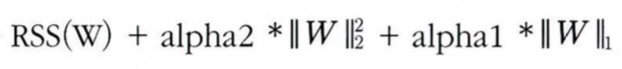

라쏘 회귀의 강한 선택적 성향을 완화시키기 위해 라쏘 회귀에 L2 규제를 추가한 것.
단점은 L1 규제와 L2 규제가 결합되었기 때문에 수행 시간이 상당히 오래 걸림

주요 파라미터: alpha, l1_ratio

이때 alpha는 릿지와 라쏘 클래스의 것과는 다름. 엘라스틱넷의 규제는 a*L1 + b*L2로 정의될 수 있으며, a와 b는 각 회귀의 규제 alpha값

l1_ratio 파라미터 값은 a / (a+b)

a = 0이면 L2 규제와 동일, b = 0이면 L1 규제와 동일


In [ ]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas,
                                        X_data_n=X_data, y_target_n=y_target)

###### ElasticNet ######
alpha 0.07일 때 5 folds의 평균 RMSE : 5.542
alpha 0.1일 때 5 folds의 평균 RMSE : 5.526
alpha 0.5일 때 5 folds의 평균 RMSE : 5.467
alpha 1일 때 5 folds의 평균 RMSE : 5.597
alpha 3일 때 5 folds의 평균 RMSE : 6.068


In [ ]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by = sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


라쏘보다는 회귀 계수들 값이 상대적으로 0이 되는 값이 적음

# 선형 회귀 모델을 위한 데이터 변환

선형 모델은 일반적으로 피처와 타깃값 간에 선형의 관계가 있다고 가정하고, 이러한 최적의 선형함수를 찾아내 결괏값을 예측함. 또, 피처값과 타깃값의 분포가 정규분포일 경우 예측 성능이 좋음 -> 왜곡된 형태의 분포일 경우 예측 성능에 부정적 영향 가능성 높음

따라서 선형 회귀 모델을 적용하기 전에 먼저 데이터에 대한 스케일링/정규화 작업을 수행하는 것이 일반적

그러나 스케일링/정규화 작업을 선행한다고 해서 무조건 예측 성능이 향상되는 것은 아님. 분포도 왜곡이 심할 때에 변환 작업이 효과적

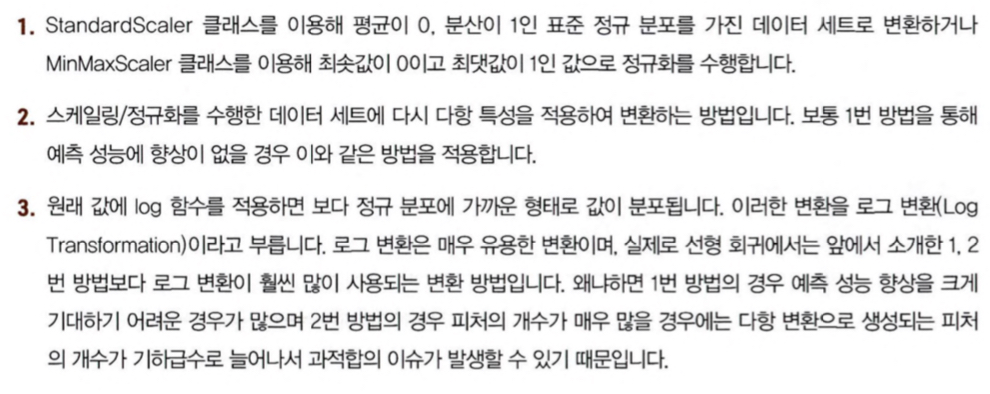

타깃값의 경우는 일반적으로 로그 변환을 사용함. 결정 값을 정규 분포나 다른 정규값으로 변환하면 변환된 값을 다시 원본 타깃값으로 복원하기 어려울 수 있기 때문이며, 로그 변환이 왜곡된 분포도에서 성능 향상을 이끌어 내는 경우가 많음.

np.log() 대신 np.log1p를 이용하면 언더 플로우를 예방하는 효과 존재.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_defree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여하지 않음.
def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log':
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data

  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree,
                                     include_bias=False).fit_transform(scaled_data)

  return scaled_data

In [ ]:
# Ridge의 alpha값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출.
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 먼저 원본 그대로, 표준정규 분포, 표준정규분포 + 다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그변환
scale_methods = [(None, None), ('Standard', None), ('Standard', 2),
                 ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
  X_data_scaled = get_scaled_data(method=scale_method[0],
                                  p_degree=scale_method[1],
                                  input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled,
                      y_target_n=y_target, verbose=False, return_coeff = False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 folds의 평균 RMSE : 5.826
alpha 1일 때 5 folds의 평균 RMSE : 5.803
alpha 10일 때 5 folds의 평균 RMSE : 5.637
alpha 100일 때 5 folds의 평균 RMSE : 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 folds의 평균 RMSE : 8.827
alpha 1일 때 5 folds의 평균 RMSE : 6.871
alpha 10일 때 5 folds의 평균 RMSE : 5.485
alpha 100일 때 5 folds의 평균 RMSE : 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 folds의 평균 RMSE : 5.764
alpha 1일 때 5 folds의 평균 RMSE : 5.465
alpha 10일 때 5 folds의 평균 RMSE : 5.754
alpha 100일 때 5 folds의 평균 RMSE : 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 folds의 평균 RMSE : 5.298
alpha 1일 때 5 folds의 평균 RMSE : 4.323
alpha 10일 때 5 folds의 평균 RMSE : 5.185
alpha 100일 때 5 folds의 평균 RMSE : 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 f

# 로지스틱 회귀

선형 회귀 방식을 분류에 적용한 알고리즘. 로지스틱 회귀는 분류에 사용됨

회귀의 선형/비선형 구별 기준: 독립변수가 아닌 가중치 변수가 선형인지 아닌지에 따라 결정됨

로지스틱 회귀와 선형 회귀의 다른 점:
학습을 통해 선형 함수의 회귀 최적선을 찾는 것이 아니라 시그모이드 함수 최적선을 찾고 이 시그모이드 함수의 반환 값을 확률로 간주해 확률에 따라 분류를 결정함 (항상 0과 1 사이 유지)

선형 회귀보다 더 유연하게 분류 가능
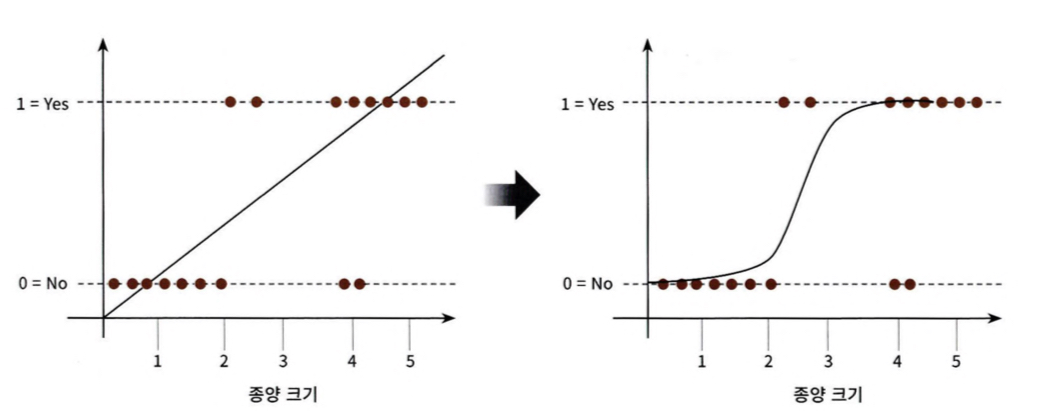

In [ ]:
from ast import increment_lineno
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행.
# solver 인자값을 생성자로 입력하지 않으면 solver = 'lbfgs
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

# accuracy와 roc_auc 측정
print('accuracy: {0:.3f}, roc_auc:{1:.3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

accuracy: 0.977, roc_auc:0.995


In [ ]:
# 특정 solver는 최적화에 상대적으로 많은 반복 횟수가 필요할 수 있음

solver = ['lbfgs', 'newton-cg', 'sag', 'saga']

# 여러 개의 solver 값별로 LogisticRegression 학습 후 성능 평가
for solver in solver:
    lr_clf = LogisticRegression(solver=solver, max_iter = 600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

    # accuracy와 roc_auc 측정
    print('solver:{0}, accuracy: {1:.3f}, roc_auc:{2:.3f}'.format(solver,
                                                                  accuracy_score(y_test, lr_preds),
                                                                  roc_auc_score(y_test, lr_preds_proba)))

solver:lbfgs, accuracy: 0.977, roc_auc:0.995
solver:newton-cg, accuracy: 0.977, roc_auc:0.995
solver:sag, accuracy: 0.982, roc_auc:0.995
solver:saga, accuracy: 0.982, roc_auc:0.995


주요 하이퍼 파라미터로는 solver, max_iter, penalty, c 존재.

penalty: 규제 유형 설정 (기본값 l2)

C: 규제 강도 조절하는 alpha 값의 역수, 작을수록 규제 강도 큼

lbfgs, newton-cg, sag는 L2 규제만 가능

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'solver': ['liblinear', 'lbfgs'],
          'penalty': ['l2', 'l1'],
          'C': [0.01, 0.1, 1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring = 'accuracy', cv = 3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_,
                                                  grid_clf.best_score_))


최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.979


# 회귀 트리

분류 트리가 특정 클래스 레이블을 결정하는 것과는 달리 회귀 트리는 리프 노드에 속한 데이터 값의 평균값을 구해 회귀 예측값을 계산

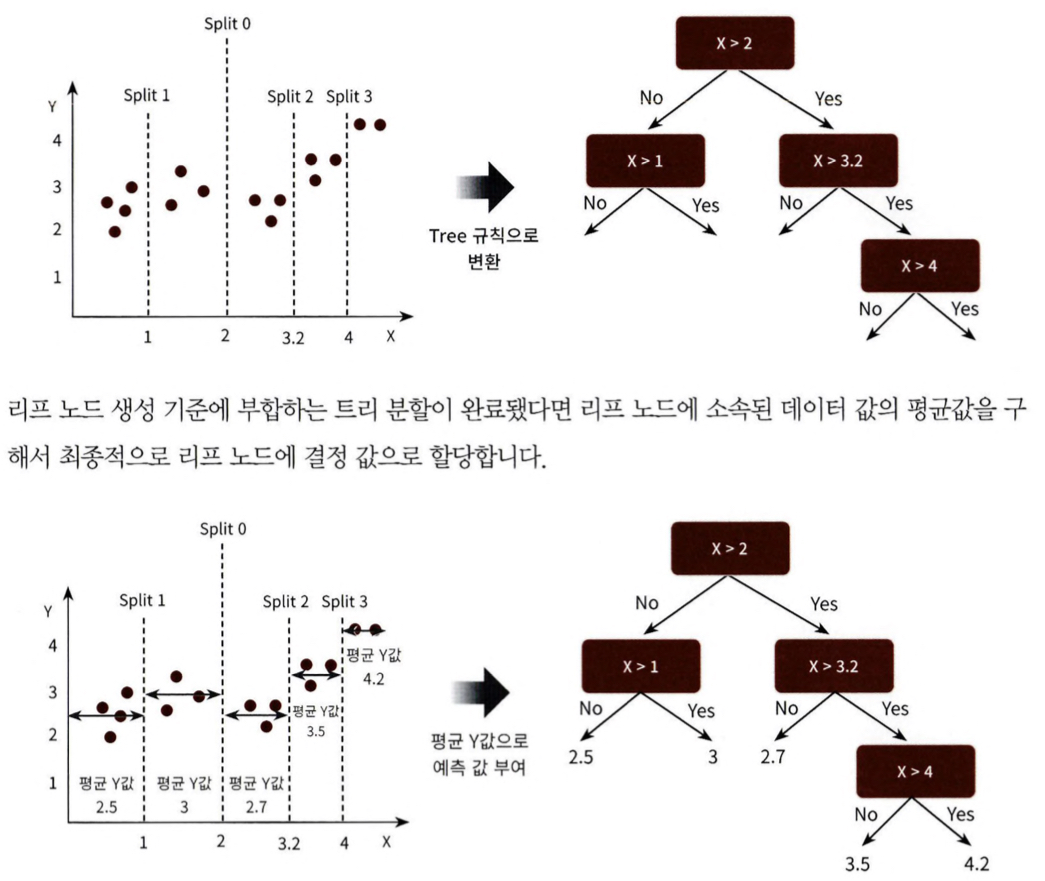

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.datasets import fetch_openml

# boston 데이터 세트 로드
boston = fetch_openml(name="boston", version=1, as_frame=True)
X = boston.data
y = boston.target

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)
bostonDF['RAD'] = bostonDF['RAD'].astype(float)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE 칼럼으로 DataFrame에 추가함.
bostonDF['PRICE'] = boston.target.astype(float)

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
X_data = X_data.apply(pd.to_numeric, errors='coerce')
X_data = X_data.fillna(0)

In [ ]:
rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(rf, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 교차 검증의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))

 5 교차 검증의 개별 Negative MSE scores:  [ -7.88 -13.14 -20.57 -46.23 -18.88]
 5 교차 검증의 개별 RMSE scores :  [2.81 3.63 4.54 6.8  4.34]
 5 교차 검증의 평균 RMSE : 4.423


In [ ]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ',model.__class__.__name__ , ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

# 트리 기반의 회귀 모델을 반복하면서 평가 수행
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

<Axes: xlabel='None', ylabel='None'>

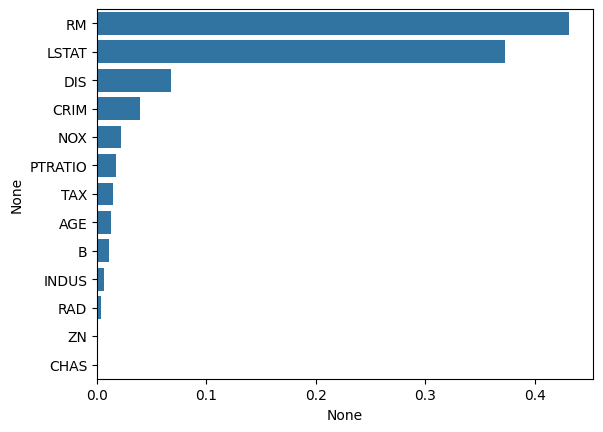

In [ ]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습합니다.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 14)


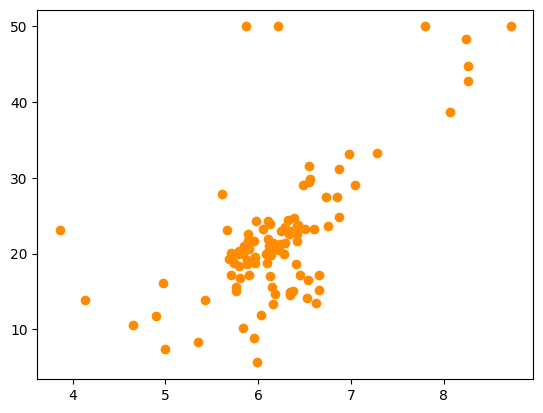

In [43]:
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')

In [44]:
import numpy as np
from sklearn.linear_model import LinearRegression

# 선형 회귀와 결정 트리 기반의 Regressor 생성. DecisionTreeRegressor의 max_depth는 각각 2,7

lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth = 2)
rf_reg7 = DecisionTreeRegressor(max_depth = 7)

# 실제 예측을 적용할 테스트용 데이터 세트를 4.5~8.5까지의 100개 데이터 세트로 생성.
X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

# 보스턴 주택 가격 데이터에서 시각화를 위해 피처는 RM만, 그리고 결정 데이터인 PRICE 추출

X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_feature = bostonDF_sample['PRICE'].values.reshape(-1, 1)

# 학습과 예측 수행
lr_reg.fit(X_feature, y_feature)
rf_reg2.fit(X_feature, y_feature)
rf_reg7.fit(X_feature, y_feature)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

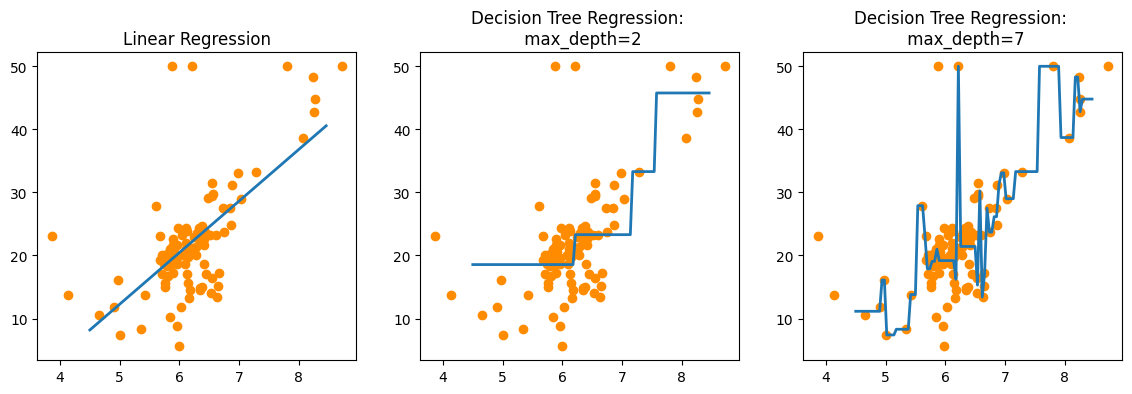

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols = 3)

# X축 값을 4.5~8.5로 변환하며 입력했을 때 선형 회귀와 결정 트리 회귀 예측선 시각화
# 선형 회귀로 학습된 모델 회귀 예측선
ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

# DecisionTreeRegressor의 max_depth를 2로 했을 때 회귀 예측선
ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:2', linewidth=2)

# DecisionTreeRegressor의 max_depth를 7로 했을 때 회귀 예측선
ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c = 'darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)


선형 회귀는 직선으로 예측 회귀선을 표현하는 데 반해, 회귀 트리의 경우 분할되는 데이터 지점에 따라 브랜치를 만들면서 계단 형태로 회귀선을 만듦
그러나 깊이가 깊을수록 이상치 데이터도 학습하면서 복잡한 계단 형태의 회귀선이 만들어져 과적합되기 쉬운 모델이 될 수 있으니 적절한 하이퍼 파라미터 조정이 필요